<center> <h1> A Pizza the Profit </h1> </center>
<center> <h2> Sales Regression Analysis for a local Pizza franchise </center> </h2> 
<center> <img src="./Images/ivan-torres-MQUqbmszGGM-unsplash.jpg" alt="Pizza" width="800"/> </center>
<center> Photo by <a href="https://unsplash.com/@iavnt?utm_source=unsplash&utm_medium=referral&utm_content=creditCopyText">Ivan Torres</a> on <a href="https://unsplash.com/s/photos/pizza?utm_source=unsplash&utm_medium=referral&utm_content=creditCopyText">Unsplash</a></center>


##### Due to the nature of the business problem and the proprietary data, all personally identifiable information has been scrubbed from the notebooks and omitted from the repository. 

#### Stakeholder & Business Problem: A local pizza franchise looking to bring in new customers and encourage existing customers to continue returning. It is my goal to identify if a specific discount code or dollar value is the most likely to increase sales and by what amount.

## Data Understanding: 

#### Data collected is from business backend sales software. I have a plethora of reports including a Sales Summary, Order History, Discounts Report, Operations Report and Marketing Report. 

 * Sales Report has 188 columns - a lot of which are irrelevant and have zeros (for example, Pass Through Fee Total, Donations, Due Amount Payable, Due Amount Receivable, House Account Receivable Tips, Gift Sales Payable Tips, Store Credit Sales Payable Tips, Lia Deposits Payable Tips, Lia Deposits Receivable Tips all have zeros and likely will not provide much insight for this analysis and could be dropped. Due to only having August 2020 to Feb 2022 sales information, this ends up at a 520 row dataframe. Not enough data for modeling per project requirements, but enough to potentially be useful for other statistical analysis in the EDA section.
 

  * Discount codes could provide valuable insight as to what customers are using and what they're not, as well as what avenues they're coming in from. This will prove to be a challenge to model with the number of unique discount codes in the hundreds and being categorical features that will require encoding. To get these reports and codes into a modelable state, I've merged the Order History and Order Discounts reports together on order number, giving me over 5000 unique order numbers to model. From there, I will prepare the merged dataframe for modeling.
  
  
  * The marketing report provides insight as to which coupon codes and from which campaign are utilized. There are tabs for Valpak, Menu Mailers, Jumbo Postcards, and Scratcher mailers that mailed over various weeks and time periods. These reports also contain response to the mailer information, as well as revenue uplift, gross profit, and ROI information. During my analysis, I discovered that the Menu Mailers tab was incorrectly totaled, and communicated this with the stakeholder so as to ensure that any action he was already taking based on that report took this error into account. The total responses were miscalculated, which then threw off all of the profit and ROI information by about 26%. While these are useful reports in Excel for a stakeholder, they are difficult to manipulate. This was an extensive cleaning process and is described separately below. There is not enough data within these reports to model and utilize machine learning for identification of optimal marketing strategy. Will use descriptive and inferential statistics strategies in the EDA section at the bottom of this notebook to communicate findings with the stakeholder. Data cleaning and preparation steps for this analysis will be outlined in the Marketing Data Preparation section below.
  
  
  * I was also provided a PDF transaction report. Much of that shows the MailShark costs which are captured in the Excel sheet. The other costs reflected in the PDF are Facebook costs. When discussed with the Business Owner about quantifying the effectiveness of the marketing campaign on Facebook (ie - what metrics did they provide to evaluate performance?), I was advised that the majority of the costs seen on that report are for hiring advertising, not marketing for sales. Therefore, this PDF will not be utilized for this analysis at this time.
      * However, of interest during this discussion, it was noted that one ad was run for a 'Customer Appreciation Day' on Facebook that was largely successful. The cost was \\$300 and their orders for the day tripled. Normal order volume ranges from 75-100 and spiked to 300 before 6 pm, phones had to be shut off. Cost of a pizza for that promotion was about \\$7 that day. This is verbal from stakeholder. Will attempt to quantify this through inferential statistics strategies.
      

 * Additional reports provided include:
     * Sales by Class which provides the sales amounts in both dollar value and volume by the item class sold. Digging into sales by specific item would be an interesting topic for futher analysis.
     * Voids/Returns which provides a similar style report to the discount code report, but for returns and voids with their reasonings.

In [1]:
import pandas as pd
import seaborn as sns
sales_2021 = pd.read_csv('./Data/Sales_Summary_fircrest-wa-est53_2021-02-01_03-00_2022-02-01_03-00.csv')

In [2]:
sales_2020 = pd.read_excel('./Data/Aug 20 to Jan 21 Sales Summary.xlsx')
#sales_2020

In [3]:
#Keep only pertinent columns and concatenate 2020 and 2021 DF's, summing columns together
columns = ['Time To', 'Gross Sales', 'Net Sales', 'Total Orders','To Go', 'Delivery', 'Pick Up', 
           'Item Discounts', 'Order Discounts Total', 'Sales Tax', 'Cash Total', 
           'Credit Total', 'Tips Total', 'Refunds Total']
total_daily_sales = pd.concat([sales_2020, 
                         sales_2021]).groupby('Time To')[columns].sum().reset_index()
total_daily_sales = total_daily_sales[columns]


In [4]:
#rename 'Time To column' to "Date" and set as index
total_daily_sales.rename(columns={'Time To': 'Date'}, inplace=True)
total_daily_sales.set_index('Date', inplace=True)

In [5]:
from datetime import datetime

In [6]:
#undo change of Date to index, drop "total" row (not needed) and change to DateTime object
total_daily_sales.reset_index(inplace=True)
total_daily_sales.drop(index=total_daily_sales[total_daily_sales['Date'] == 'Total'].index, inplace=True)
total_daily_sales['Date'] = pd.to_datetime(total_daily_sales.Date)

In [7]:
discounts_2020 = pd.read_excel('./Data/Aug 20 to Jan 21 Ops.xlsx', sheet_name='Discounts')

In [8]:
discounts_2021 = pd.read_excel('./Data/Sales by Class -Ops.xlsx', sheet_name='Discounts')

In [9]:
discounts_2021.nunique()

DISCOUNT REASON    205
Qty                 45
Total              166
dtype: int64

In [10]:
#concatenate 2020 and 2021 discount code dataframes and sum columns together, sort to top 20
total_discounts = pd.concat([discounts_2020, 
                             discounts_2021]).groupby('DISCOUNT REASON')['Qty', 
                                                                         'Total'].sum().reset_index()


<ipython-input-10-af795b2c4f92>:2: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  total_discounts = pd.concat([discounts_2020,


In [11]:
#standard and loyalty are determined to be "type" classes and totals, not actual discounts
#need to drop these
total_discounts.drop(index=total_discounts[total_discounts['DISCOUNT REASON'] 
                                           == 'Loyalty'].index, inplace=True)

In [12]:
#Drop 'TOTAL' from DF - not needed and will impede resampling
total_discounts.drop(index=total_discounts[total_discounts['DISCOUNT REASON'] 
                                           == 'TOTAL'].index, inplace=True)

In [13]:
total_discounts.sort_values('Qty', ascending=False)

,DISCOUNT REASON,Qty,Total
389,Standard,14727.0,80575.10
259,MAIL25,4296.0,15869.27
333,Pizza Points,3624.0,25655.19
12,25 Off Online,1672.0,6014.48
368,SAVE20,1498.0,3967.60
...,...,...,...
151,Feed the family coupon,1.0,11.48
150,Fb 5 off,1.0,5.00
148,EotM,1.0,25.49
147,Entertainment book coupon,1.0,8.49


In [14]:
sales_by_class_2020 = pd.read_excel('./Data/Aug 20 to Jan 21 Ops.xlsx', sheet_name='Sales by Class')
sales_by_class_2020.set_index('SALES BY CLASS', inplace=True)

In [15]:
sales_by_class_2021 = pd.read_excel('./Data/Sales by Class -Ops.xlsx')
sales_by_class_2021.set_index('SALES BY CLASS', inplace=True)

In [16]:
#tons of blank NA columns and rows from import of excel - drop them
sales_by_class_2021.isna().sum().sum()

3130

In [17]:
#dropping null/blank cells that imported - of no use
sales_by_class_2021.dropna(inplace=True)

In [18]:
#concatenate 2020 and 2021 sales by class reports
sales_by_class = pd.concat([sales_by_class_2020, sales_by_class_2021]).groupby('SALES BY CLASS')['Raw Qty', 
                                                                               'Raw Sales',
                                                                               'Voids/Returns Qty',
                                                                                'Voids/Returns', 'Comps Qty',
                                                                               'Comps',
                                                                               'Gross Sales',
                                                                               'Item Disc',
                                                                               'Order Disc',
                                                                                'Net Totals'].sum().reset_index()


<ipython-input-18-af329d6fa378>:2: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  sales_by_class = pd.concat([sales_by_class_2020, sales_by_class_2021]).groupby('SALES BY CLASS')['Raw Qty',


In [19]:
#drop 'Total' row from DF, is not needed and will impede resampling.
sales_by_class.drop(index=sales_by_class[sales_by_class['SALES BY CLASS'] 
                                           == 'Total'].index, inplace=True)
#sales_by_class

In [20]:
refunds_2021 = pd.read_excel('./Data/Sales by Class -Ops.xlsx', sheet_name='Refunds')

In [21]:
refunds_2021.nunique()

VOIDS, RETURNS AND COMPS REASON    136
T                                    3
Qty                                 16
Total                              102
dtype: int64

In [22]:
total_refunds = pd.concat([refunds_2021, pd.read_excel('./Data/Aug 20 to Jan 21 Ops.xlsx', sheet_name='Returns')
                          ]).groupby('VOIDS, RETURNS AND COMPS REASON')['T','Qty','Total'].sum().reset_index()
total_refunds.sort_values('Qty', ascending=False).head(20)

<ipython-input-22-9e8afdd0edcd>:1: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  total_refunds = pd.concat([refunds_2021, pd.read_excel('./Data/Aug 20 to Jan 21 Ops.xlsx', sheet_name='Returns')


,"VOIDS, RETURNS AND COMPS REASON",Qty,Total
112,Mistake,545,6190.45
102,Late,26,135.65
104,Late missing items,22,36.03
18,Cancelled by DoorDash,20,16.74
62,Deal,17,312.08
80,Doordash switched on me!,17,21.73
89,Duplicate order,16,235.09
32,Changed order,14,220.39
169,Waste,13,140.40
93,Entered twice,13,139.66


In [23]:
#Bring in Aug 2020 to Feb 2022 Order History
order_history = pd.read_excel('./Data/Order_History_Aug to Feb combined.xlsx')
#order_history

In [24]:
#Bring in Aug 2020 to Feb 2022 Discount Code history by Order Number
order_discounts = pd.read_excel('./Data/Discounts_combined.xlsx')
#order_discounts 

In [25]:
#combine together - now we have a complete DF of orders with associated discount codes.
orders_by_discounts = order_history.merge(order_discounts, on='Order Num')

In [26]:
#checking duplicate order numbers, looks like we have quite a few.
orders_by_discounts['Order Num'].nunique()

5204

In [27]:
#dropping the columns that won't be needed here
orders_by_discounts.drop(columns = ['Date_y', 'Created By', 'Taxed', 'Order Payments', 'Quantity'], inplace=True)

In [28]:
#rename the date column and change to a date time object
orders_by_discounts.rename(columns={'Date_x': 'Date'}, inplace=True)
orders_by_discounts['Date'] = pd.to_datetime(orders_by_discounts.Date)

In [29]:
#make the summed discount values a series to fill the new column
series = pd.DataFrame(orders_by_discounts.groupby('Order Num')['Amount'].sum())
series

,Amount
Order Num,
349235,5.25
349475,6.75
349627,7.00
349668,2.75
349855,22.99
...,...
1494852,6.75
1495524,28.55
1495587,9.00


In [30]:
#join the item strings together and make them a series to replace in the column
item_series = orders_by_discounts.groupby('Order Num', as_index = False).agg({'Item': ','.join})

In [31]:
#drop the duplicate orders and replace the column values with the series summations 
disc_orders = orders_by_discounts.drop_duplicates(subset=['Order Num'], inplace=True)
disc_orders = orders_by_discounts.merge(series, on='Order Num')

In [32]:
#merge in the items
disc_orders = disc_orders.merge(item_series, on='Order Num')

In [33]:
#drop the original Amount and Item columns that are no longer needed and rename the new columns
disc_orders.drop(columns=['Amount_x', 'Item_x'], inplace=True)
disc_orders.rename(columns={'Amount_y': 'Total Discount Amount', 'Item_y': 'Items Ordered'}, inplace=True)
#disc_orders

In [34]:
disc_orders['Discount Code'].value_counts().head(50)

MAIL25                           2000
GET25OFF                          888
SAVE20                            428
GET25EMPLOYEE                     340
GET25MILITARY                     225
7-7-7 Deal                         95
DMPAIR1                            84
Reading Program Free Personal      81
GET25HOTEL                         81
$4 Off Any Pizza                   69
Movers Free Medium                 66
COLRG1                             65
DMDIN3                             59
DMMED2                             54
GET25FREE                          52
WINGS1                             48
100% Off                           48
GET25MILTARY                       46
GET25DMLG                          37
FREE MED 1 TOP                     25
Free Large Pizza Card              24
Hotel Front Desk                   23
DMMED3                             19
35% Off 3 Large Pizzas             19
FREEMDM                            18
Free Birthday Pizza                15
DMFAV1      

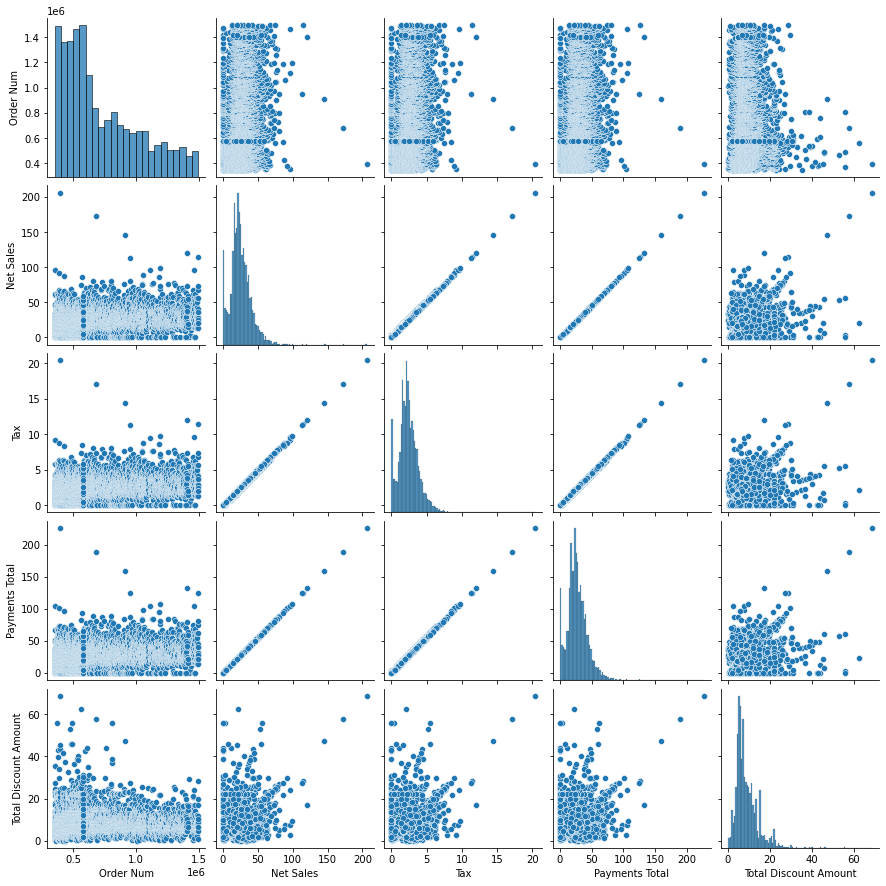

In [35]:
sns.pairplot(disc_orders);

In [36]:
# function borrowed from Stack Overflow - link below to dummy out most frequent discount codes only
# https://stackoverflow.com/questions/18016495/get-subset-of-most-frequent-dummy-variables-in-pandas
def dum_sign(dummy_col, threshold=0.20):

    # removes the bind
    dummy_col = dummy_col.copy()

    # what is the ratio of a dummy in whole column
    count = pd.value_counts(dummy_col) / len(dummy_col)

    # cond whether the ratios is higher than the threshold
    mask = dummy_col.isin(count[count > threshold].index)

    # replace the ones which ratio is lower than the threshold by a special name
    dummy_col[~mask] = "others"

    return pd.get_dummies(dummy_col, prefix=dummy_col.name)

In [37]:
#taking top 50ish only discount codes for analysis and one hot encoding them for modeling
code_ohe = dum_sign(disc_orders['Discount Code'], threshold=0.0003)
disc_orders_cat = pd.concat([disc_orders, code_ohe], axis=1)
#disc_orders_cat

In [38]:
#drop original discount code column as well as other columns not needed at this time
disc_orders_cat.drop(columns=['Tax', 'Discount Code', 'Employee', 'Payments Total'], inplace=True)
disc_orders_cat

,Order Num,Date,Net Sales,Total Discount Amount,Items Ordered,Discount Code_$4 Off Any Pizza,Discount Code_100% Off,Discount Code_35% Off 3 Large Pizzas,Discount Code_7-7-7 Deal,Discount Code_Bogo,...,Discount Code_GET25SCRATCH,Discount Code_Hotel Front Desk,Discount Code_LARGEFAV,Discount Code_MAIL25,Discount Code_Movers Free Medium,Discount Code_Reading Program Free Personal,Discount Code_SALAD1,Discount Code_SAVE20,Discount Code_WINGS1,Discount Code_others
0,580979,2021-01-01 15:01:07,40.36,25.49,Large The Big Kahuna,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,580995,2021-01-01 15:08:01,19.74,4.00,Grand Build Your Own Pizza,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,581092,2021-01-01 15:36:35,35.60,11.87,"Bread Stix,Medium Gourmet Veggie,Large BBQ Chi...",0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,581463,2021-01-01 16:46:00,31.99,15.00,"1-Topping Medium Pizza 8-8-8,1-Topping Medium ...",0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
4,581535,2021-01-01 16:55:33,13.88,4.63,Large Build Your Own Pizza,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5199,578180,2020-12-31 12:22:48,25.49,15.00,"Calzone 8-8-8,1-Topping Medium Pizza 8-8-8",0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
5200,1417244,2021-12-31 15:44:06,58.37,14.60,"Large Build Your Own Pizza,Large Tropical Heat...",0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
5201,1417317,2021-12-31 15:56:50,14.28,8.50,"Garden Salad,Large Westside",0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
5202,1417572,2021-12-31 16:23:01,19.49,6.50,Large Build Your Own Pizza,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0


In [39]:
#sanity check 
disc_orders_cat[disc_orders_cat['Order Num'] == 1417832]

,Order Num,Date,Net Sales,Total Discount Amount,Items Ordered,Discount Code_$4 Off Any Pizza,Discount Code_100% Off,Discount Code_35% Off 3 Large Pizzas,Discount Code_7-7-7 Deal,Discount Code_Bogo,...,Discount Code_GET25SCRATCH,Discount Code_Hotel Front Desk,Discount Code_LARGEFAV,Discount Code_MAIL25,Discount Code_Movers Free Medium,Discount Code_Reading Program Free Personal,Discount Code_SALAD1,Discount Code_SAVE20,Discount Code_WINGS1,Discount Code_others
5203,1417832,2021-12-31 16:47:21,54.44,16.5,"2L Sierra Mist,Chocolate Chip Cookie,Large Wes...",0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0


In [40]:
#dropping the date and setting the order number as the index
disc_orders_cat.drop(columns='Date', inplace=True)
disc_orders_cat.set_index('Order Num', inplace=True)
disc_orders_cat

,Net Sales,Total Discount Amount,Items Ordered,Discount Code_$4 Off Any Pizza,Discount Code_100% Off,Discount Code_35% Off 3 Large Pizzas,Discount Code_7-7-7 Deal,Discount Code_Bogo,Discount Code_COLRG1,Discount Code_COLRG2,...,Discount Code_GET25SCRATCH,Discount Code_Hotel Front Desk,Discount Code_LARGEFAV,Discount Code_MAIL25,Discount Code_Movers Free Medium,Discount Code_Reading Program Free Personal,Discount Code_SALAD1,Discount Code_SAVE20,Discount Code_WINGS1,Discount Code_others
Order Num,,,,,,,,,,,,,,,,,,,,,
580979,40.36,25.49,Large The Big Kahuna,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
580995,19.74,4.00,Grand Build Your Own Pizza,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
581092,35.60,11.87,"Bread Stix,Medium Gourmet Veggie,Large BBQ Chi...",0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
581463,31.99,15.00,"1-Topping Medium Pizza 8-8-8,1-Topping Medium ...",0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
581535,13.88,4.63,Large Build Your Own Pizza,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
578180,25.49,15.00,"Calzone 8-8-8,1-Topping Medium Pizza 8-8-8",0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1417244,58.37,14.60,"Large Build Your Own Pizza,Large Tropical Heat...",0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
1417317,14.28,8.50,"Garden Salad,Large Westside",0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0


## Marketing Expense Data Cleaning

For the purpose of the analysis, I will break each mailer type into a DF for costs and response versus total sent for each type. Data is from August 2020 through December 2021 for this Marketing information. I will make the dates DateTime objects for usability later - in case TimeSeries analysis proves to be valuable. Each type has a "Total" column in it's dataframe that will need to be dropped. 

   * During my analysis, it is discovered that the reports provided are not totaled correctly, so the values in the provided Excel report are not calculated correctly. The values in my DataFrames differed, and when I went to do a sanity check to confirm my values and concatenations came through correctly, I discovered summations were improperly performed within Excel, which resulted in the revenue and ROI figures to be off by approximately 26%. I did advise the stakeholder as soon as it was discovered.

   * Valpak does not provide a number of what was sent out to compare the responses to, whereas the other three categories do. Eliminating ValPak from analysis for the time being.

#### Jumbo Mailers
Jumbo Mailers ran Jan through Sept 2021 according to the household mailer column, though I only see costs associated with January. 

#### Scratch Off Mailers
Scratch Off mailers ran October through December of 2020.

#### Menu Mailers
Menu Mailers ran August through October of 2020.

In [41]:
#importing the Jumbo Postcard mailers
jumbo = pd.read_excel('./Data/Fircrest Direct Mail ROI Report.xlsx', sheet_name='Jumbo PC')

In [42]:
#selecting the responses/codes only and separating the costs.
jumbo_responses = jumbo.iloc[2:10]
jumbo_responses = jumbo_responses.T
jumbo_responses.dropna(inplace=True)

In [43]:
#set the mailer codes to the column headers
header = jumbo_responses.iloc[0]
jumbo_responses = jumbo_responses[1:]
jumbo_responses.columns = header

In [44]:
#drop 'Total' row from DF, is not needed and will impede resampling.
jumbo_responses.drop(index=jumbo_responses[jumbo_responses['Fircrest - Deals'] 
                                           == 'TOTALS'].index, inplace=True)

In [45]:
#change dates to Date Time object and set to index.
jumbo_responses['Fircrest - Deals'] = pd.to_datetime(jumbo_responses['Fircrest - Deals'])
jumbo_responses.set_index('Fircrest - Deals', inplace=True)
jumbo_responses

Unnamed: 1,DM777,SALAD1,WINGS1,FREEMDM,MAIL25,Total # of Responses,Households Mailed To
Fircrest - Deals,,,,,,,
2021-01-01,112,4,32,6,270,424,555
2021-02-01,27,8,7,7,149,198,556
2021-03-01,0,0,0,0,0,0,556
2021-04-01,0,0,0,0,0,0,556
2021-05-01,0,0,0,0,0,0,556
2021-06-01,0,0,0,0,0,0,556
2021-07-01,0,0,0,0,0,0,555
2021-08-01,0,0,0,0,0,0,555
2021-09-01,0,0,0,0,0,0,555


In [46]:
#split out the marketing costs for the jumbo mailers
jumbo_costs = jumbo.iloc[12:21]
jumbo_costs = jumbo_costs.T
jumbo_costs.dropna(inplace=True)


In [47]:
#set the cost buckets to column headers
costs_header = jumbo_costs.iloc[0]
jumbo_costs = jumbo_costs[1:]
jumbo_costs.columns = costs_header

In [48]:
#drop total from DF as it will impede resampling. Change Date to datetime object and reset to index
jumbo_costs.drop(index=jumbo_costs[jumbo_costs['Fircrest - Costs & Profit'] 
                                           == 'TOTALS'].index, inplace=True)
jumbo_costs['Fircrest - Costs & Profit'] = pd.to_datetime(jumbo_costs['Fircrest - Costs & Profit'])
jumbo_costs.set_index('Fircrest - Costs & Profit', inplace=True)
jumbo_costs

Unnamed: 1,Weekly Mailng Cost,Social Media Boosting,Food and Labor,Total Weekly Cost,Total Revenue Uplift,Weekly Gross Profit Subtotal,Less 9.9% Sales Tax,Net Profit Totals
Fircrest - Costs & Profit,,,,,,,,
2021-01-01,2496,100,3992.28,6588.28,6653.8,65.52,658.726,-593.206
2021-02-01,0,0,0,0,0,0,0,0
2021-03-01,0,0,0,0,0,0,0,0
2021-04-01,0,0,0,0,0,0,0,0
2021-05-01,0,0,0,0,0,0,0,0
2021-06-01,0,0,0,0,0,0,0,0
2021-07-01,0,0,0,0,0,0,0,0
2021-08-01,0,0,0,0,0,0,0,0
2021-09-01,0,0,0,0,0,0,0,0


In [49]:
#repeat steps above for Menu Mailers and Scratchers for both Costs and Responses
menu = pd.read_excel('./Data/Fircrest Direct Mail ROI Report.xlsx', sheet_name='Menu Mailers')


In [50]:
menu_responses = menu.iloc[2:9]
menu_responses = menu_responses.T
menu_responses.dropna(inplace=True)

In [51]:
header = menu_responses.iloc[0]
menu_responses = menu_responses[1:]
menu_responses.columns = header

In [52]:
menu_responses.drop(index=menu_responses[menu_responses['Fircrest - Deals'] 
                                           == 'TOTALS'].index, inplace=True)
menu_responses['Fircrest - Deals'] = pd.to_datetime(menu_responses['Fircrest - Deals'])
menu_responses.set_index('Fircrest - Deals', inplace=True)


In [53]:
menu_costs = menu.iloc[11:20]
menu_costs = menu_costs.T
menu_costs.dropna(inplace=True)

In [54]:
costs_header = menu_costs.iloc[0]
menu_costs = menu_costs[1:]
menu_costs.columns = costs_header

In [55]:
menu_costs.drop(index=menu_costs[menu_costs['Fircrest - Costs & Profit'] 
                                           == 'TOTALS'].index, inplace=True)
menu_costs['Fircrest - Costs & Profit'] = pd.to_datetime(menu_costs['Fircrest - Costs & Profit'])
menu_costs.set_index('Fircrest - Costs & Profit', inplace=True)


In [56]:
scratchers = pd.read_excel('./Data/Fircrest Direct Mail ROI Report.xlsx', sheet_name='Scratchers')

In [57]:
scratcher_responses = scratchers.iloc[2:17]
scratcher_responses = scratcher_responses.T
scratcher_responses.dropna(inplace=True)

In [58]:
header = scratcher_responses.iloc[0]
scratcher_responses = scratcher_responses[1:]
scratcher_responses.columns = header

In [59]:
scratcher_responses.drop(index=scratcher_responses[scratcher_responses['Fircrest - Deals'] 
                                           == 'TOTALS'].index, inplace=True)
scratcher_responses['Fircrest - Deals'] = pd.to_datetime(scratcher_responses['Fircrest - Deals'])
scratcher_responses.set_index('Fircrest - Deals', inplace=True)


In [60]:
scratcher_costs = scratchers.iloc[19:28]
scratcher_costs = scratcher_costs.T
scratcher_costs.dropna(inplace=True)

In [61]:
header = scratcher_costs.iloc[0]
scratcher_costs = scratcher_costs[1:]
scratcher_costs.columns = header


In [62]:
scratcher_costs.drop(index=scratcher_costs[scratcher_costs['Fircrest - Costs & Profit'] 
                                           == 'TOTALS'].index, inplace=True)
scratcher_costs['Fircrest - Costs & Profit'] = pd.to_datetime(scratcher_costs['Fircrest - Costs & Profit'])
scratcher_costs.set_index('Fircrest - Costs & Profit', inplace=True)


In [63]:
#gearing up for another concatenation - add marketing type to columns for concat for clarity. 
scratcher_costs.rename(columns={'Total Weekly Cost': 'Total Weekly Cost - Scratcher', 
                               'Total Revenue Uplift': 'Total Revenue Uplift - Scratcher',
                               'Net Profit Totals': 'Net Profit Totals - Scratcher'}, inplace= True)


In [64]:
menu_costs.rename(columns={'Total Weekly Cost': 'Total Weekly Cost - Menu Mail', 
                               'Total Revenue Uplift': 'Total Revenue Uplift - Menu Mail',
                               'Net Profit Totals': 'Net Profit Totals - Menu Mail'}, inplace= True)


In [65]:
jumbo_costs.rename(columns={'Total Weekly Cost': 'Total Weekly Cost - Jumbo PC', 
                               'Total Revenue Uplift': 'Total Revenue Uplift - Jumbo PC',
                               'Net Profit Totals': 'Net Profit Totals - Jumbo PC'}, inplace= True)
jumbo_costs = jumbo_costs[jumbo_costs['Total Weekly Cost - Jumbo PC'] > 0]


In [66]:
scratcher_responses.rename(columns={'Total # of Responses': 'Total # of Responses- Scratchers',
                                    'Households Mailed To': 'Households Mailed To - Scratchers'}, inplace= True)


In [67]:
jumbo_responses.rename(columns={'Total # of Responses': 'Total # of Responses- Jumbo PC',
                                    'Households Mailed To': 'Households Mailed To - Jumbo PC'}, inplace= True)
jumbo_responses = jumbo_responses[jumbo_responses['Households Mailed To - Jumbo PC'] > 0]


In [68]:
menu_responses.rename(columns={'Total # of Responses': 'Total # of Responses- Menu Mail',
                                    'Households Mailed To': 'Households Mailed To - Menu Mail'}, inplace= True)


In [69]:
#prep for combining the newly renamed columns 
menu_resp_col = menu_responses[['Total # of Responses- Menu Mail', 'Households Mailed To - Menu Mail']]
menu_cost_col = menu_costs[['Total Weekly Cost - Menu Mail','Total Revenue Uplift - Menu Mail',
                           'Net Profit Totals - Menu Mail']]
#merge menu costs and responses together on column axis
menu_merge = pd.concat([menu_resp_col, menu_cost_col], axis=1)

#repeat for jumbo
jumbo_resp_col = jumbo_responses[['Total # of Responses- Jumbo PC', 'Households Mailed To - Jumbo PC']]
jumbo_cost_col = jumbo_costs[['Total Weekly Cost - Jumbo PC','Total Revenue Uplift - Jumbo PC',
                             'Net Profit Totals - Jumbo PC']]
jumbo_merge = pd.concat([jumbo_resp_col, jumbo_cost_col], axis=1)

#repeat for scratchers
scratch_resp_col = scratcher_responses[['Total # of Responses- Scratchers', 'Households Mailed To - Scratchers']]                      
scratch_cost_col = scratcher_costs[['Total Weekly Cost - Scratcher','Total Revenue Uplift - Scratcher',
                                   'Net Profit Totals - Scratcher']]
scratch_merge = pd.concat([scratch_resp_col, scratch_cost_col], axis=1)


In [70]:
#concat the three merged marketing cost and response DF's together into one big DF and fill the NA's with zeros
#because the marketing campaigns ran at different times, the nulls can be filled with zeros where missing
marketing = pd.concat([menu_merge, jumbo_merge, scratch_merge])
marketing.fillna(value='0', inplace=True)

In [71]:
#converting to numeric types - all obejcts for some reason.
marketing = marketing.apply(pd.to_numeric)

In [72]:
#adding a revenue uplift column that sums the uplift for a given week based on marketing response.
uplift_columns = ['Total Revenue Uplift - Menu Mail', 'Total Revenue Uplift - Jumbo PC', 
                  'Total Revenue Uplift - Scratcher']
marketing['Overall Total Revenue Uplift'] = marketing[uplift_columns].sum(axis=1)
#marketing

In [73]:
#correcting Date index name, and sorting by date.
marketing.reset_index(inplace=True)
marketing.rename(columns={'index': 'Date'}, inplace=True)
marketing.set_index('Date', inplace=True)
marketing = marketing.sort_index()
#marketing

In [74]:
#summing up the number of responses and total sent out for each type of mailer
mm_responses = menu_responses['Total # of Responses- Menu Mail'].sum()
mm_sent = menu_responses['Households Mailed To - Menu Mail'].sum()
jumbo_resp = jumbo_responses['Total # of Responses- Jumbo PC'].sum()
jumbo_sent = jumbo_responses['Households Mailed To - Jumbo PC'].sum()
scratcher_resp = scratcher_responses['Total # of Responses- Scratchers'].sum()
scratcher_sent = scratcher_responses['Households Mailed To - Scratchers'].sum()

In [75]:
#combining all of the types together along with their counts of sent and total responses
total_marketing = pd.DataFrame(index=['Menu Mailers', 'Jumbo Mailers', 'Scratchers'], 
                               columns=['Reponses', 'Sent'],data=[[mm_responses, mm_sent],
                                                                  [jumbo_resp, jumbo_sent], [scratcher_resp, 
                                                                                             scratcher_sent]])


In [76]:
#summing up the costs for each marketing mailer type and adding it to the marketing dataframe
menu_cost = menu_costs['Total Weekly Cost - Menu Mail'].sum()
jumbo_cost = jumbo_costs['Total Weekly Cost - Jumbo PC'].sum()
scratcher_cost = scratcher_costs['Total Weekly Cost - Scratcher'].sum()

total_marketing['Cost'] = [menu_cost, jumbo_cost, scratcher_cost]

#total_marketing

In [77]:
#bring in the doordash marketing expenses
door_dash = pd.read_excel('./Data/doordash marketing.xlsx')
#door_dash

In [78]:
#sum up the columns for doordash
dd_sales = door_dash['Sales'].sum()
dd_customers = door_dash['Customers'].sum()
dd_cost = door_dash['Cost'].sum()

#### Adding DoorDash to the Marketing Costs DataFrame
##### Note that the "sent" column for DoorDash is purely synthetic. There is nothing to 'send' for DD. This 9999 number is a random value and would likely be a low number given the time period and number of users on DoorDash. See this article for DoorDash user statistics. https://www.businessofapps.com/data/doordash-statistics/

In [79]:
DoorDash = [dd_customers, 9999, dd_cost]
total_marketing.loc[3] = (DoorDash)
total_marketing.rename(index={3: 'Doordash'}, inplace=True)
#total_marketing

In [80]:
#reseting the index and renaming to "Type" for visualization in EDA section.
total_marketing.reset_index(inplace=True)
total_marketing.rename(columns={'index': 'Type'}, inplace=True)

In [81]:
total_marketing['Cost Per Response'] = round(total_marketing['Cost'] / total_marketing['Reponses'], 2)
total_marketing

,Type,Reponses,Sent,Cost,Cost Per Response
0,Menu Mailers,728.0,15000.0,11824.826,16.24
1,Jumbo Mailers,622.0,5000.0,6588.280,10.59
2,Scratchers,825.0,15000.0,15023.520,18.21
3,Doordash,110.0,9999.0,881.970,8.02


## Pickling 

### This was extensive data cleaning and prep. To save time and energy, I'll utilize Pandas to_pickle() for me to save these DataFrames as pickle files and call them back up in a secondary Modeling notebook. This will keep the notebooks cleaner, and more readable, as well as sharpening my skills with Pickle!

##### I have commented out the cells below so that the files are not saved to your directory if/when you run this notebook. Should you need to pickle these, simply uncomment the cells below.

&nbsp;

<center> <img src="./Images/jason-leung-0dMWA0W4eKA-unsplash.jpg" alt="Careful with Pickles!" width="500"/> </center>
<center>Photo by <a href="https://unsplash.com/@ninjason?utm_source=unsplash&utm_medium=referral&utm_content=creditCopyText">Jason Leung</a> on <a href="https://unsplash.com/s/photos/pickle?utm_source=unsplash&utm_medium=referral&utm_content=creditCopyText">Unsplash</a></center>

In [82]:
import pickle

In [83]:
#condensed marketing cost and responses to Pickle file
#total_marketing.to_pickle('total_marketing_condensed')

In [84]:
#total refunds DF to pickle file
#total_refunds.to_pickle('total_refunds')

In [85]:
#all sales by class saved to pickle file
#sales_by_class.to_pickle('sales_by_class')

In [86]:
#all discounts from Sales reports pickle file
#total_discounts.to_pickle('total_discounts')

In [87]:
#all sales report to pickle file
#total_daily_sales.to_pickle('total_sales')

In [88]:
#pickle the combined marketing DF that has all the pertinent info.
#marketing.to_pickle('total_marketing')

In [89]:
#pickle my order history dataframe
#orders_by_discounts.to_pickle('discount_order_history')

In [90]:
#encoded discount order history DF - primary modeling DF
#disc_orders_cat.to_pickle('disc_orders_ohe')

## EDA 

In [91]:
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import numpy as np

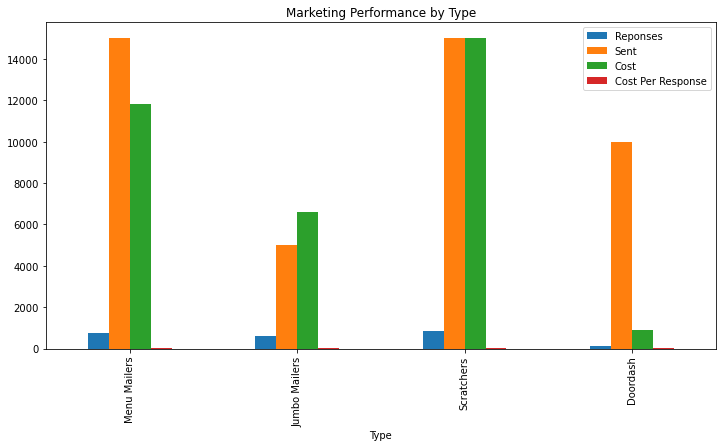

In [92]:
#performance by marketing type. Shows cost, total sent and total responses by type
total_marketing.plot(x='Type', kind='bar', title='Marketing Performance by Type',
                     figsize=(12,6));

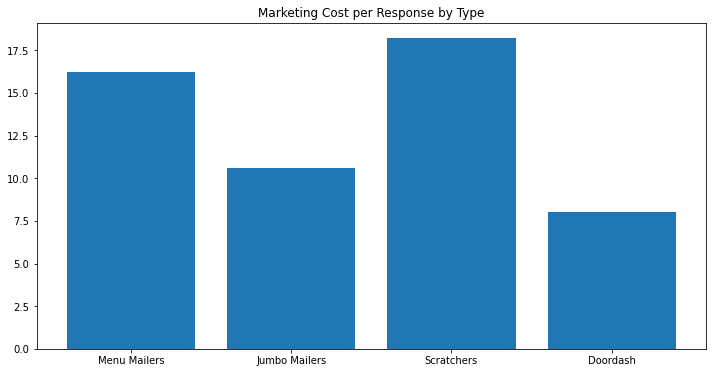

In [93]:
#figured cost per response by each type, and graphed. 
costs_per_response = total_marketing['Cost'] / total_marketing['Reponses']
fig = plt.subplots(figsize=(12,6))
plt.bar(total_marketing['Type'], costs_per_response)
plt.title('Marketing Cost per Response by Type')
plt.show()

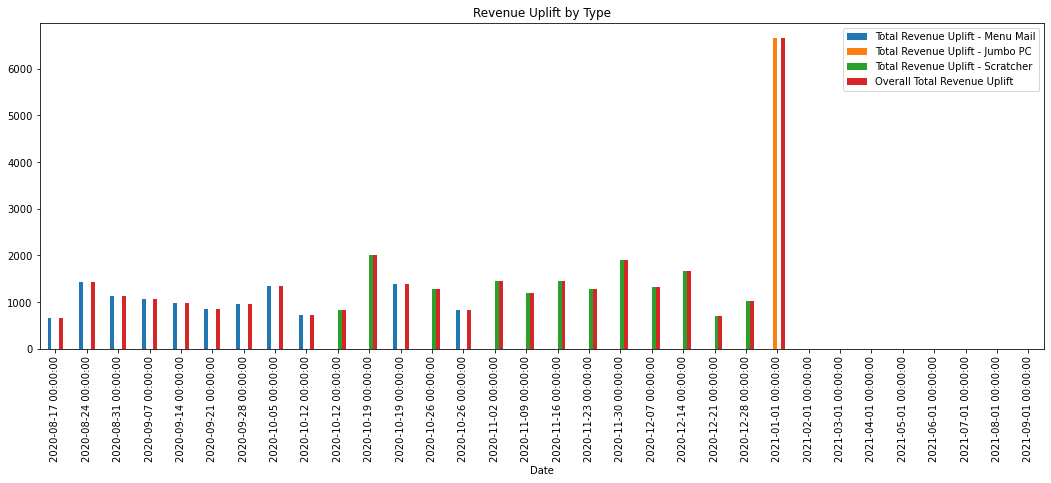

In [94]:
#visualizing the total revenue uplift by type by week. Jumbo PC only has one value- monthly - so this is skewed.
uplift_columns2 = ['Total Revenue Uplift - Menu Mail', 'Total Revenue Uplift - Jumbo PC', 
                  'Total Revenue Uplift - Scratcher', 'Overall Total Revenue Uplift']
marketing[uplift_columns2].plot(kind='bar', title='Revenue Uplift by Type', figsize=(18,6))
plt.show()

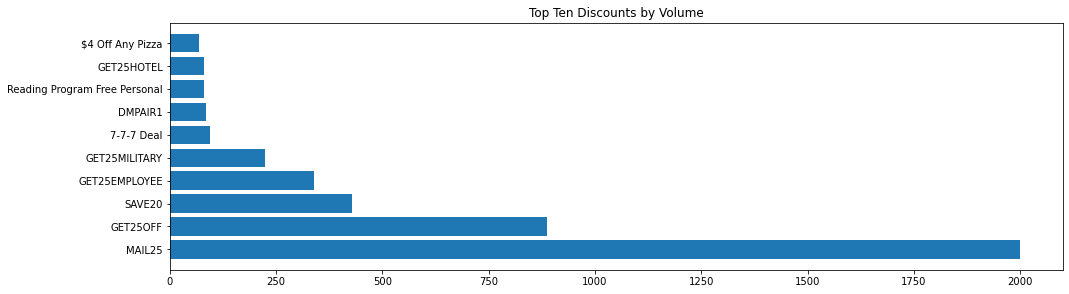

In [95]:
top_10_discounts_vol = orders_by_discounts['Discount Code'].value_counts()
top_10_discounts_vol = top_10_discounts_vol.sort_values(ascending=False).head(10)
fig, ax = plt.subplots(figsize=(16,10))
plt.subplot(211)
plt.barh(top_10_discounts_vol.index, top_10_discounts_vol.values)
plt.title('Top Ten Discounts by Volume');

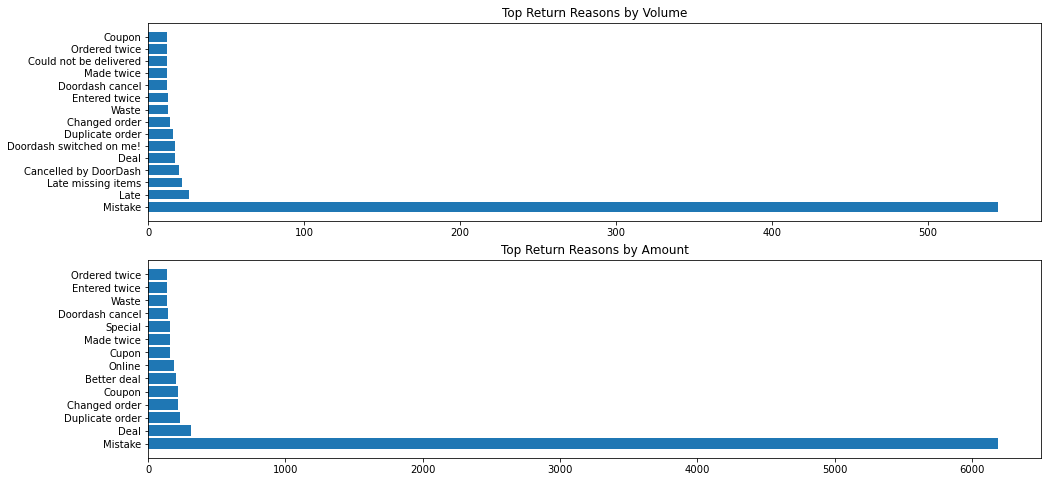

In [96]:
#most frequent reasons for return
most_returns_vol = total_refunds.sort_values(by='Qty', ascending=False).head(15)
most_common_returns_value =  total_refunds.groupby('VOIDS, RETURNS AND COMPS REASON')['Total'].sum()
most_common_returns_value = most_common_returns_value.sort_values(ascending=False).head(15)
x = most_common_returns_value.index[0:14]
y = most_common_returns_value.values[0:14]
fig, ax = plt.subplots(figsize=(16,8))
plt.subplot(211)
plt.barh(most_returns_vol['VOIDS, RETURNS AND COMPS REASON'], most_returns_vol['Qty'])
plt.title('Top Return Reasons by Volume')
plt.subplot(212)
plt.barh(x, y)
plt.title('Top Return Reasons by Amount')
plt.show()

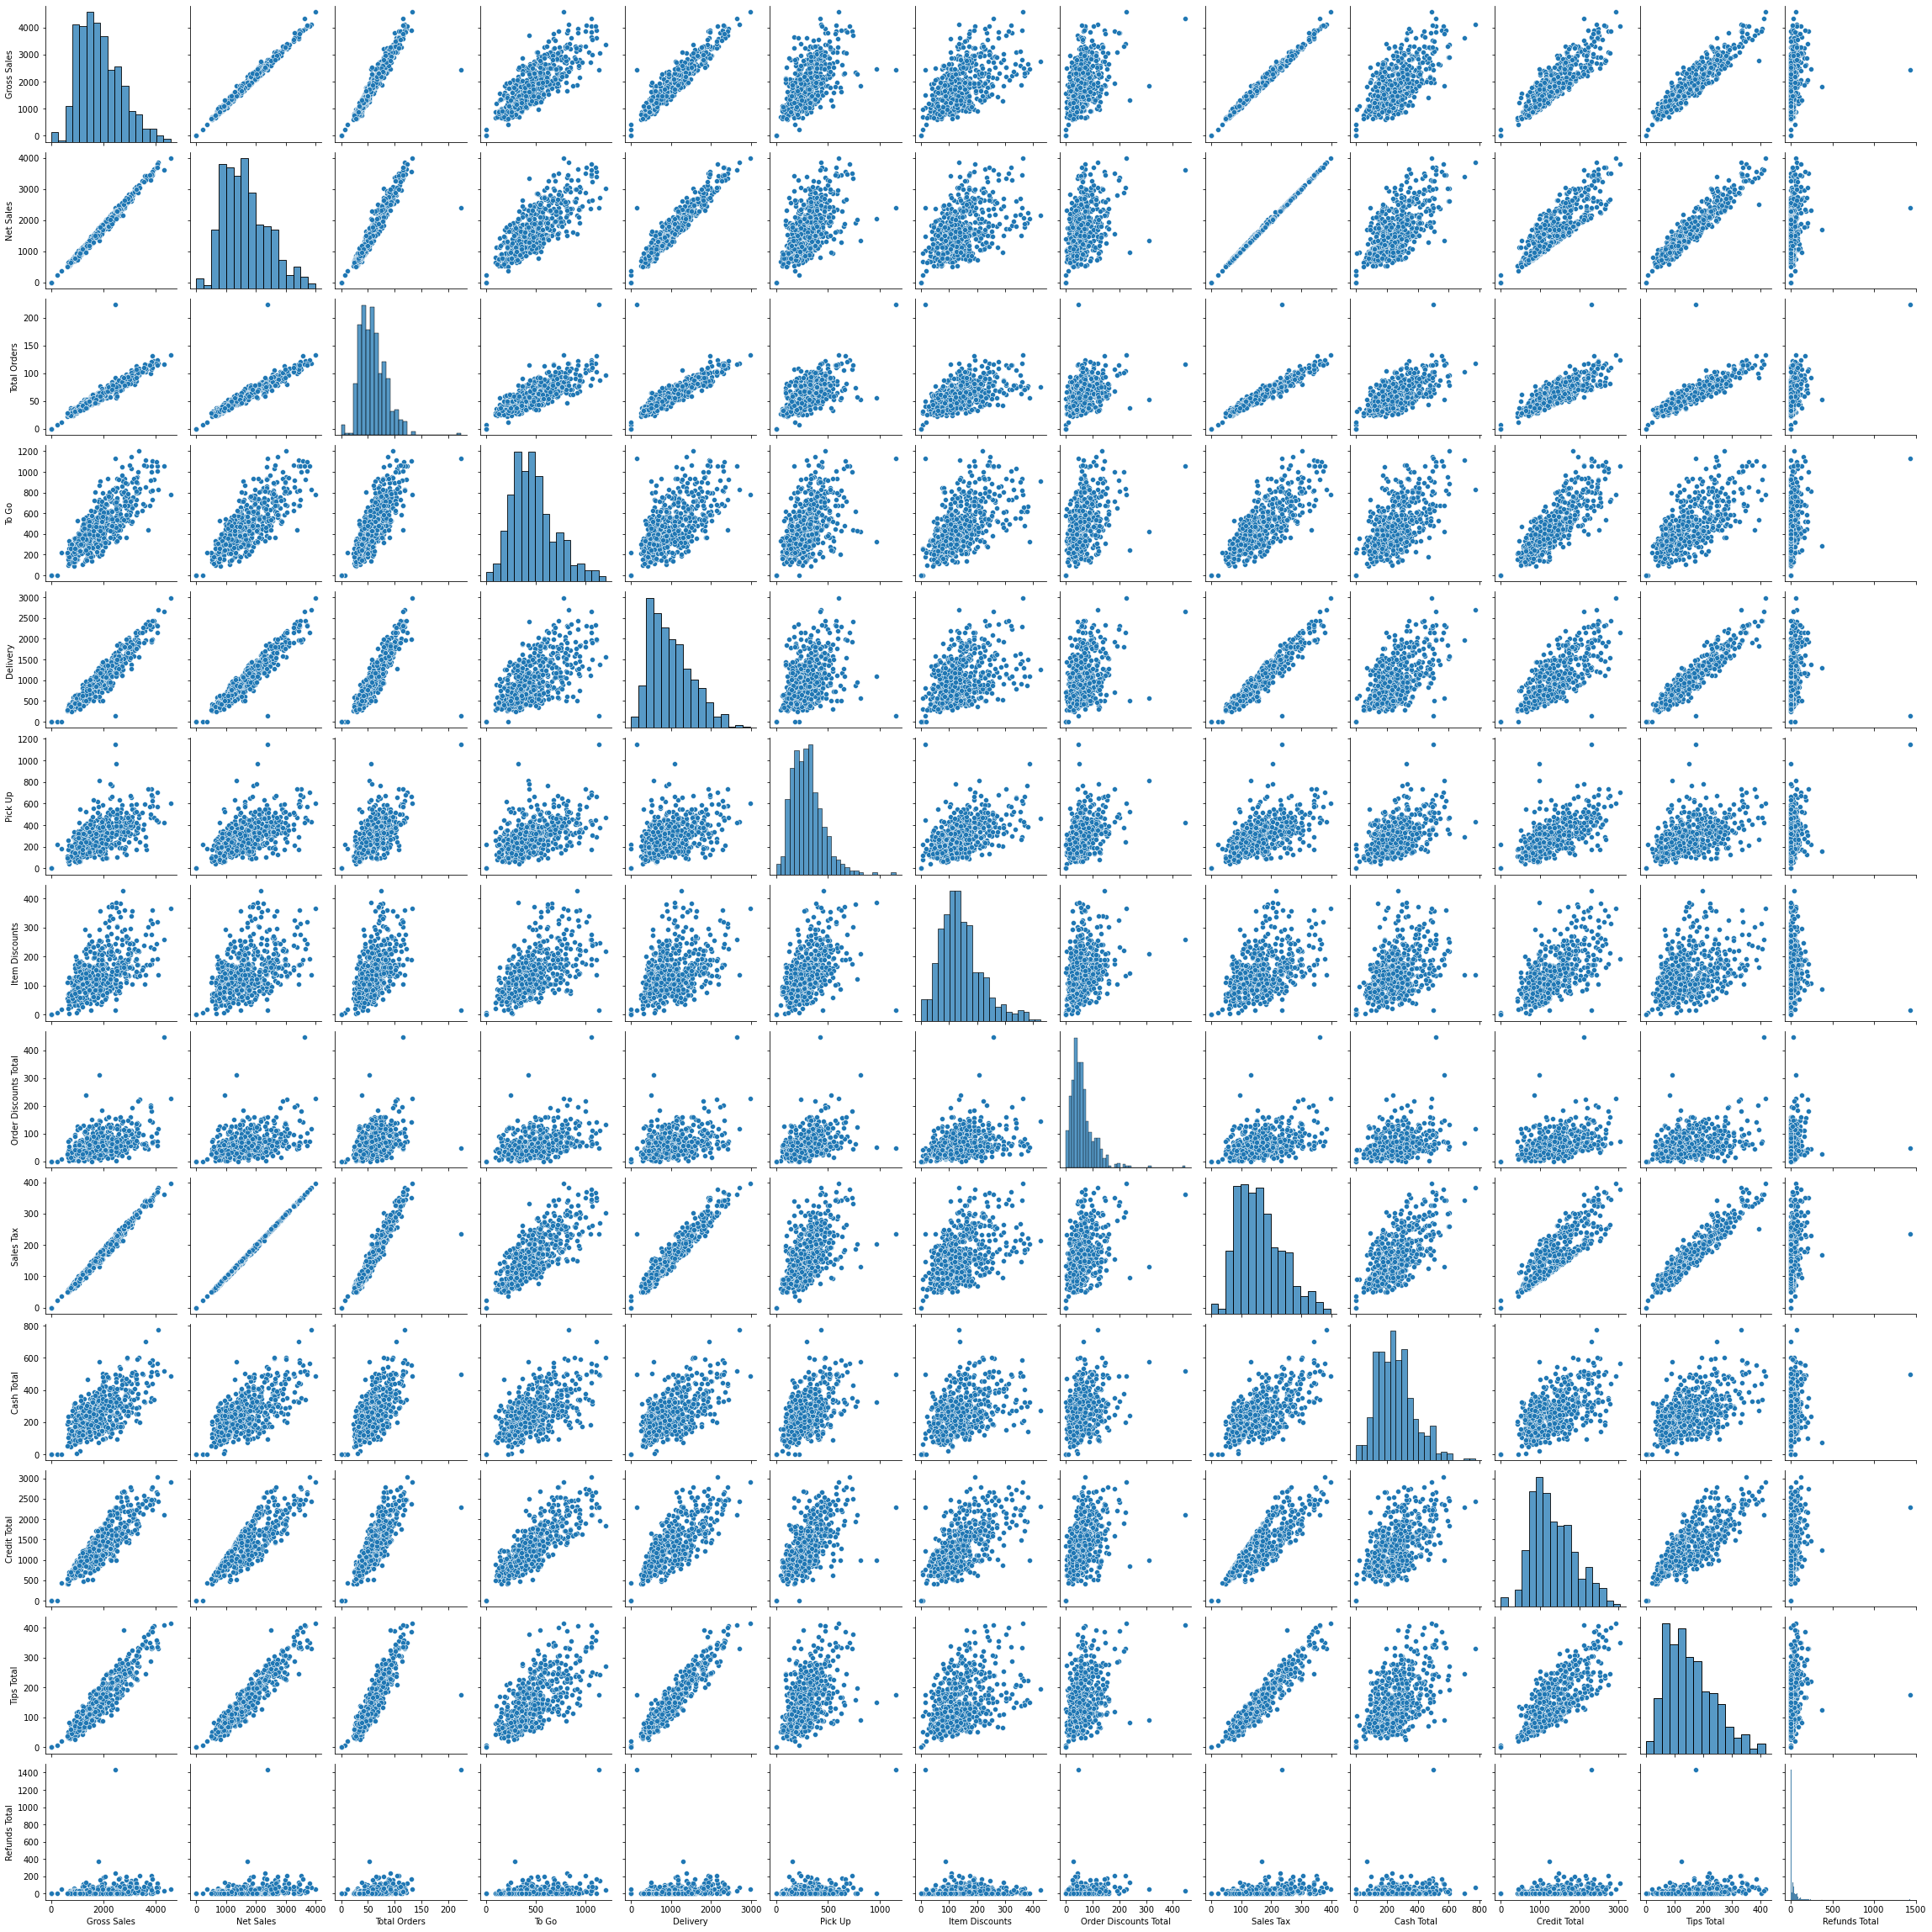

In [97]:
#visuals of total daily sales feature relationships
sns.pairplot(total_daily_sales);

<AxesSubplot:>

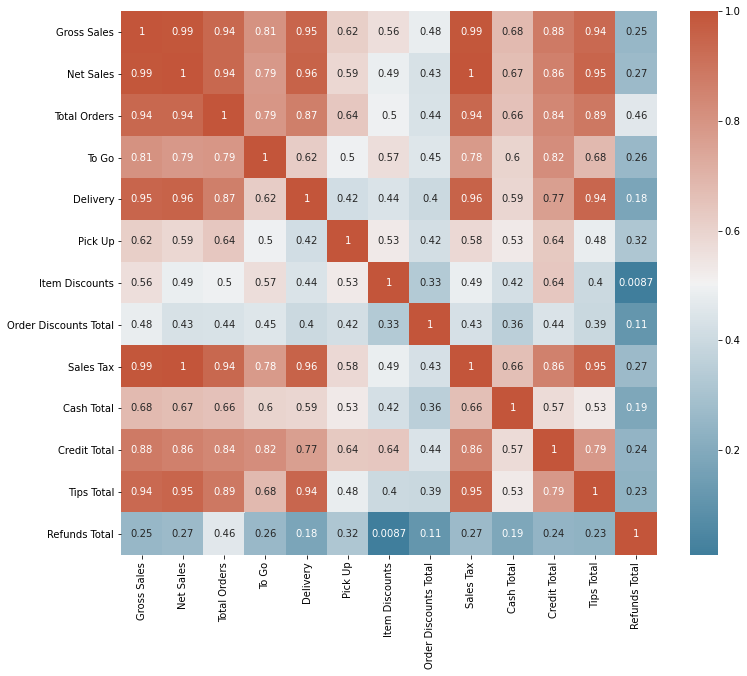

In [98]:
#checking correlation of daily sales factors
corr = total_daily_sales.corr()
f, ax = plt.subplots(figsize=(12, 10))
cmap = sns.diverging_palette(230, 20, as_cmap=True)
sales_heatmap = sns.heatmap(corr, annot=True, cmap=cmap);
sales_heatmap

In [99]:
disc_orders_cat.describe()

,Net Sales,Total Discount Amount,Discount Code_$4 Off Any Pizza,Discount Code_100% Off,Discount Code_35% Off 3 Large Pizzas,Discount Code_7-7-7 Deal,Discount Code_Bogo,Discount Code_COLRG1,Discount Code_COLRG2,Discount Code_Coupon,...,Discount Code_GET25SCRATCH,Discount Code_Hotel Front Desk,Discount Code_LARGEFAV,Discount Code_MAIL25,Discount Code_Movers Free Medium,Discount Code_Reading Program Free Personal,Discount Code_SALAD1,Discount Code_SAVE20,Discount Code_WINGS1,Discount Code_others
count,5204.000000,5204.000000,5204.000000,5204.000000,5204.000000,5204.000000,5204.000000,5204.000000,5204.000000,5204.000000,...,5204.000000,5204.00000,5204.000000,5204.000000,5204.000000,5204.000000,5204.000000,5204.000000,5204.000000,5204.000000
mean,25.146061,8.923013,0.013259,0.009224,0.003651,0.018255,0.001345,0.012490,0.000384,0.001922,...,0.001153,0.00442,0.002306,0.384320,0.012683,0.015565,0.001345,0.082244,0.009224,0.039201
std,14.640155,5.688206,0.114393,0.095605,0.060319,0.133886,0.036655,0.111071,0.019602,0.043798,...,0.033939,0.06634,0.047969,0.486481,0.111911,0.123797,0.036655,0.274763,0.095605,0.194091
min,0.000000,0.150000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,16.480000,5.250000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,23.475000,7.300000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,32.960000,11.120000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.00000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,206.110000,68.750000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.00000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [101]:
#Order value mean and std - determining confidence interval range
from scipy import stats
sales_by_order_mu = 25.146061
sales_by_order_sigma = 14.640155
#number of orders
n = 5204
#standard error
se= sales_by_order_sigma / (n ** 0.5)
#confidence interval
interval = stats.t.interval(alpha=.95, loc=sales_by_order_mu, scale=se, df=n-1)

conf_low = interval[0]
conf_high = interval[1]
print(conf_low)
print(conf_high)
print(interval)
#There is a 95% chance that the true population mean is within this range given the sample data provided. 

24.748204770629236
25.543917229370763
(24.748204770629236, 25.543917229370763)


/Users/aeakland/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


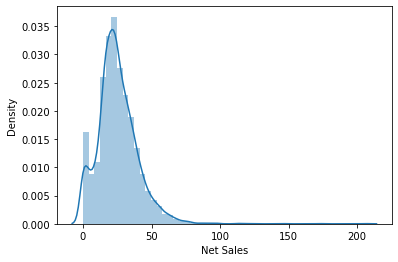

In [102]:
#target variable distribution
sns.distplot(disc_orders_cat['Net Sales']);

/Users/aeakland/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


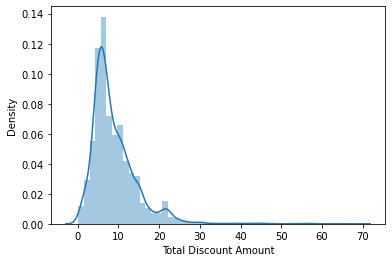

In [103]:
#discount amount distribution
sns.distplot(disc_orders_cat['Total Discount Amount']);

In [104]:
#Order discount value mean and std - determining confidence interval range
disc_val_by_order_mu = 8.923013
disc_val_by_order_sigma = 5.688206
#number of orders
orders = 5204
#standard error
serr= disc_val_by_order_sigma / (orders ** 0.5)
#confidence interval
C_interval = stats.t.interval(alpha=.95, loc=disc_val_by_order_mu, scale=serr, df=orders-1)

C_conf_low = C_interval[0]
C_conf_high = C_interval[1]
print(C_conf_low)
print(C_conf_high)
print(C_interval)
#There is a 95% chance that the true population mean is within this range given the sample data provided. 

8.768432109903948
9.07759389009605
(8.768432109903948, 9.07759389009605)


In [105]:
#Both are positively skewed and leptokurtic with Total Discount amount being much worse than Net Sales.
#Will apply scaling & norm to attempt to normalize data during modeling and meet normality assumption.
from scipy import stats
disc_amount_kurt = stats.kurtosis(disc_orders_cat['Total Discount Amount'], axis=0, fisher=True, bias=True)
disc_amount_skew = stats.skew(disc_orders_cat['Total Discount Amount'], axis=0, bias=True)
sales_skew = stats.skew(disc_orders_cat['Net Sales'], axis=0, bias=True)
sales_kurt = stats.kurtosis(disc_orders_cat['Net Sales'], axis=0, fisher=True, bias=True)
print(f'Net Sales Skew {sales_skew} and kurtosis {sales_kurt}')
print(f'Total Discount Value Skew {disc_amount_skew} and kurtosis {disc_amount_kurt}')

Net Sales Skew 1.429507127815447 and kurtosis 8.856532437698364
Total Discount Value Skew 2.453456999268349 and kurtosis 12.428969654153164


/Users/aeakland/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/Users/aeakland/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


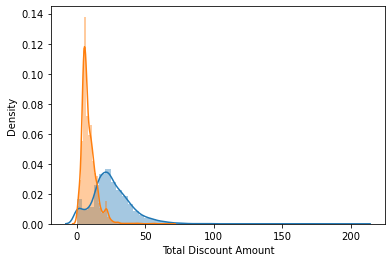

In [106]:
#together
sns.distplot(disc_orders_cat['Net Sales'])
sns.distplot(disc_orders_cat['Total Discount Amount']);
#The blue/orange lines show an estimate of the underlying distribution, this is what KDE produces.
#The KDE algorithm takes a parameter, bandwidth, that affects how “smooth” the resulting curve is. 
#Net sales more normal than Total Discount - which is very sharp

In [107]:
#normalize total discount amount to see if improvement is made
def normalize(feature):
    return (feature - feature.mean()) / feature.std()



total_discounts_norm = normalize(disc_orders_cat['Total Discount Amount'])
total_discounts_norm

Order Num
580979     2.912515
580995    -0.865477
581092     0.518087
581463     1.068349
581535    -0.754722
             ...   
578180     1.068349
1417244    0.998028
1417317   -0.074367
1417572   -0.425971
1417832    1.332052
Name: Total Discount Amount, Length: 5204, dtype: float64

/Users/aeakland/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


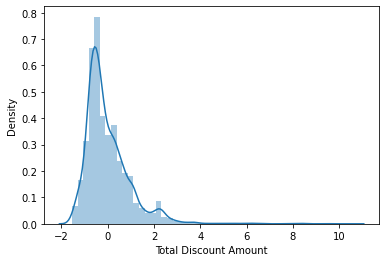

In [108]:
#plot normalized total discount amount
sns.distplot(total_discounts_norm);

In [109]:
#normalize net sales
sales_normed = normalize(disc_orders_cat['Net Sales'])
sales_normed

Order Num
580979     1.039193
580995    -0.369263
581092     0.714059
581463     0.467477
581535    -0.769532
             ...   
578180     0.023493
1417244    2.269371
1417317   -0.742209
1417572   -0.386339
1417832    2.000931
Name: Net Sales, Length: 5204, dtype: float64

/Users/aeakland/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


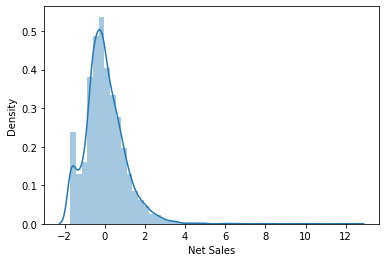

In [110]:
sns.distplot(sales_normed);

/Users/aeakland/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/Users/aeakland/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


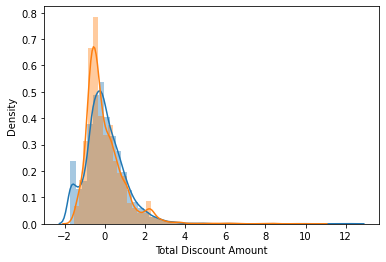

In [111]:
#they do look more "normal" but still likely have issues with skew and kurtosis that will need to be addressed
sns.distplot(sales_normed)
sns.distplot(total_discounts_norm);

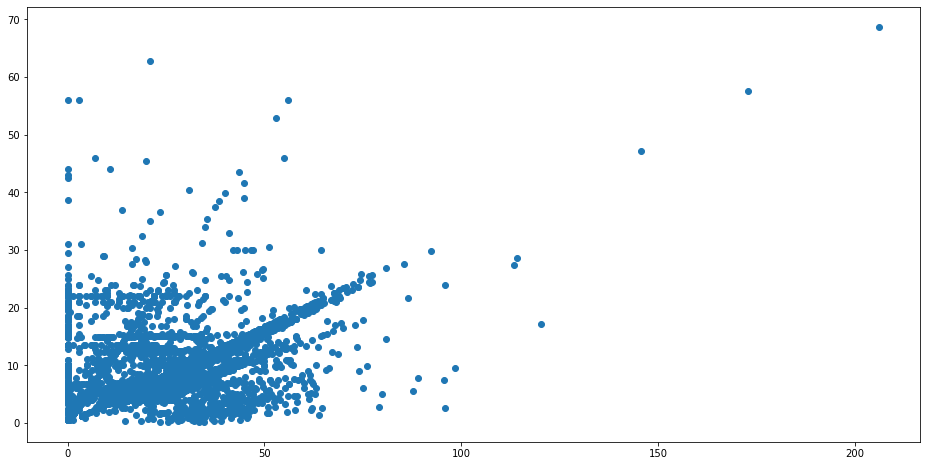

In [112]:
#check for linearity. Looks okay - outliers may be a factor
fig, ax = plt.subplots(figsize=(16,8))
x = disc_orders_cat['Net Sales']
y = disc_orders_cat['Total Discount Amount']
ax.scatter(x , y);

In [113]:
#setting a daily net sales time series 
total_daily_ts = total_daily_sales.set_index('Date')
total_daily_ts = total_daily_ts[['Net Sales']]
total_daily_ts

,Net Sales
Date,
2021-01-01 03:00:00,2353.50
2022-01-01 03:00:00,2282.34
2021-01-02 03:00:00,1642.16
2022-01-02 03:00:00,1773.35
2021-01-03 03:00:00,1516.19
...,...
2021-12-29 03:00:00,1169.21
2020-12-30 03:00:00,1077.31
2021-12-30 03:00:00,925.67


In [114]:
#adding a column for sales by day of the week
import calendar
  
total_daily_ts['Weekday'] = total_daily_ts.index.day_name()
total_daily_ts

,Net Sales,Weekday
Date,,
2021-01-01 03:00:00,2353.50,Friday
2022-01-01 03:00:00,2282.34,Saturday
2021-01-02 03:00:00,1642.16,Saturday
2022-01-02 03:00:00,1773.35,Sunday
2021-01-03 03:00:00,1516.19,Sunday
...,...,...
2021-12-29 03:00:00,1169.21,Wednesday
2020-12-30 03:00:00,1077.31,Wednesday
2021-12-30 03:00:00,925.67,Thursday


In [115]:
#group by day of the week and average
average_daily_sales = total_daily_ts.groupby('Weekday')['Net Sales'].mean()
average_daily_sales

Weekday
Friday       1513.862436
Monday       1734.064615
Saturday     2450.251410
Sunday       2170.394177
Thursday     1361.743462
Tuesday      1131.484810
Wednesday    1234.563590
Name: Net Sales, dtype: float64

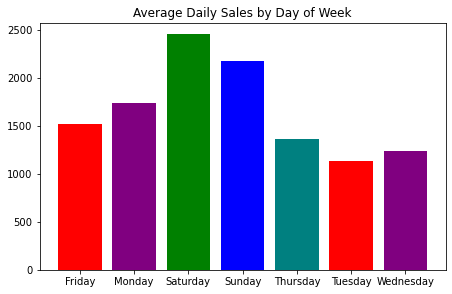

In [116]:
#net sales by day of the week
sales_by_day = total_daily_ts.groupby('Weekday')['Net Sales'].sum()
fig, ax = plt.subplots(figsize=(16,10)) 
# plt.subplot(221)
# plt.bar(sales_by_day.index, sales_by_day.values, color=['red', 'purple', 'green', 'blue', 'teal'])
# plt.title('Net Sales by Day of Week')
plt.subplot(222)
plt.bar(average_daily_sales.index, average_daily_sales.values, color=['red', 'purple', 'green', 'blue', 'teal'])
plt.title('Average Daily Sales by Day of Week');

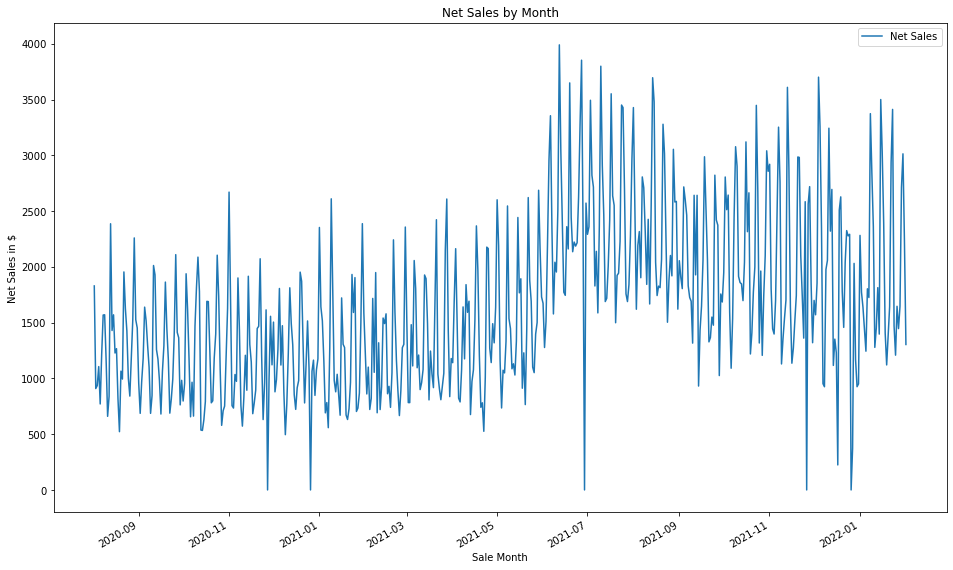

In [117]:
#visually seeing the spikes and drops by day. Also see some seasonality with summer sales being higher over winter
#and spring
total_daily_ts.plot(figsize=(16,10), xlabel='Sale Month', ylabel= 'Net Sales in $', title="Net Sales by Month");

In [118]:
#resample from daily to monthly to visualize on a monthly scale
total_monthly_sales = total_daily_ts.resample('M').sum()
total_monthly_sales

,Net Sales
Date,
2020-08-31,38650.82
2020-09-30,36285.18
2020-10-31,36977.31
2020-11-30,35291.84
2020-12-31,35441.57
2021-01-31,39310.86
2021-02-28,32470.64
2021-03-31,41149.75
2021-04-30,41168.34


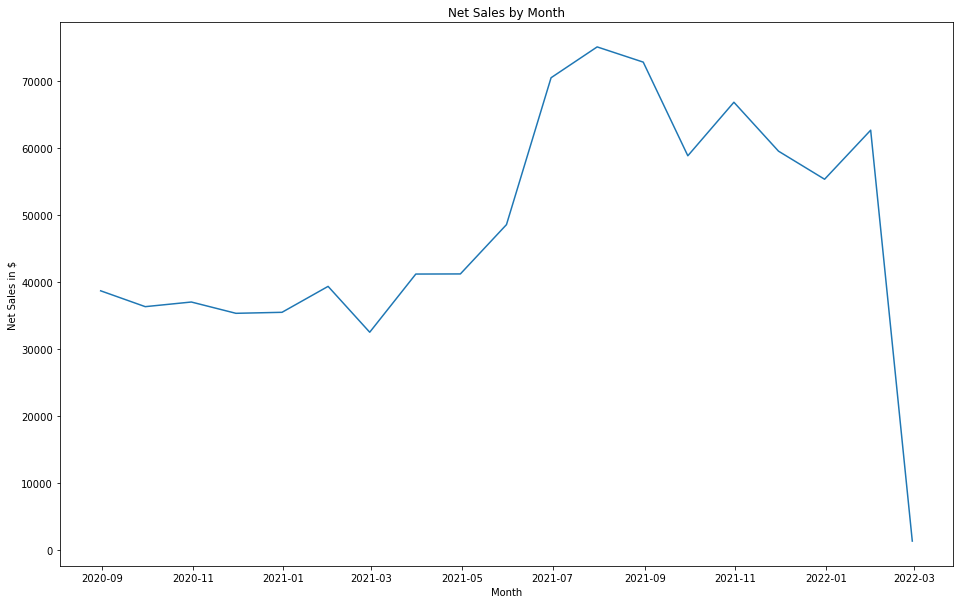

In [119]:
#plot monthly net sales
fig, ax = plt.subplots(figsize=(16,10))
ax.plot(total_monthly_sales)
ax.set_xlabel('Month')
ax.set_ylabel('Net Sales in $')
ax.set_title("Net Sales by Month");

#### Per my conversation with the stakeholder and from my analysis below, normal order volume has a median of 57 orders per day and an arithmetic mean of ~60.  The average order value on a given day is approximately \\$27.33, and the maximum order day seen in this dataset had an order count of 223 and an average order value far below the mean at only \\$10.70.  

Assuming that this day was the Facebook promo day that the stakeholder mentioned, the jump from the median of 57 orders to 223 orders represents a 291.23% increase for a cost of \\$300. Applying the same idea utilized for the other marketing avenues, an increase in responses by 166 customers from the normal ~57 to the observed 223 orders at a cost of $300 represents a cost of ~\\$1.81 per response and by far the lowest cost by marketing type observed in this analysis. The stakeholder acknowledged that there are staffing concerns to work out, as this influx overwhelmed their capabilities, but it seems a worthy path for further exploration.

In [120]:
total_daily_sales['Average Order Value'] = total_daily_sales['Net Sales']/total_daily_sales['Total Orders']

In [121]:
#mean daily net sales $1656.60/ median $1545.71
#average number of orders per day is about 60 with median being 57
#average order value of $27.33 (median $27.36)
total_daily_sales.describe()

,Gross Sales,Net Sales,Total Orders,To Go,Delivery,Pick Up,Item Discounts,Order Discounts Total,Sales Tax,Cash Total,Credit Total,Tips Total,Refunds Total,Average Order Value
count,548.000000,548.000000,548.000000,548.000000,548.000000,548.000000,548.000000,548.000000,548.000000,548.000000,548.000000,548.000000,548.000000,543.000000
mean,1860.925949,1656.602755,59.569343,476.826113,1004.830657,298.194653,143.250128,61.073066,163.662226,256.767737,1338.950109,153.775201,27.159489,27.325205
std,810.692905,750.786988,24.029018,225.605731,530.662865,148.096261,75.101966,44.341561,75.010729,121.836357,554.130584,82.986996,72.917611,3.493834
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,10.703184
25%,1247.550000,1079.320000,42.000000,314.007500,573.237500,193.565000,90.850000,33.130000,106.727500,169.820000,921.222500,87.732500,0.000000,25.103703
50%,1784.515000,1545.705000,57.000000,444.675000,903.660000,278.180000,132.360000,51.900000,152.240000,243.920000,1234.665000,138.830000,3.290000,27.361471
75%,2366.027500,2116.327500,74.000000,605.452500,1342.695000,379.895000,177.475000,77.437500,210.532500,321.672500,1691.405000,207.130000,34.382500,29.633716
max,4579.850000,3990.820000,223.000000,1198.850000,2986.100000,1148.950000,425.740000,447.250000,395.400000,772.010000,3039.940000,415.780000,1433.260000,39.520862


In [122]:
#max order day average order value far below normal average of $27.33
total_daily_sales[total_daily_sales['Total Orders'] == 223]

,Date,Gross Sales,Net Sales,Total Orders,To Go,Delivery,Pick Up,Item Discounts,Order Discounts Total,Sales Tax,Cash Total,Credit Total,Tips Total,Refunds Total,Average Order Value
266,2020-08-13 03:00:00,2447.95,2386.81,223.0,1132.65,151.4,1148.95,15.12,46.02,234.95,498.94,2297.59,174.77,1433.26,10.703184


### Please see the Modeling notebook for modeling and identification of best discount codes